# Communities and Crime Data Set

Data Set Characteristics:Multivariate | Number of Instances:1994 | Area: Social | Attribute Characteristics: Real | Number of Attributes: 128 | Date Donated: 2009-07-13 | Associated Tasks:Regression | Missing Values: Yes

**Data Set Information:**

Many variables are included so that algorithms that select or learn weights for attributes could be tested. However, clearly unrelated attributes were not included; attributes were picked if there was any plausible connection to crime (N=122), plus the attribute to be predicted (Per Capita Violent Crimes). The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units.

The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in incorrect values for per capita violent crime. These cities are not included in the dataset. Many of these omitted communities were from the midwestern USA.

**Attribute Information**: (122 predictive, 5 non-predictive, 1 goal)

In [6]:
library("data.table")
library("imputeTS")

Warning message:
"package 'imputeTS' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [8]:
# input reading
setwd("C:/IE582")

crimedat <- data.table(read.table("communities.data",sep=","))
crimedat[,1:5]<-NULL ##removing state and county names
crimedat=crimedat[ ,lapply(.SD, na_mean)] ##replacing NA's with column means
crimedat=data.frame(data.matrix(crimedat))
crime_response<-crimedat[,123]
crimedat[,123]=NULL
crimedat<-cbind(crime_response,crimedat)
colnames(crimedat)[1]="Class"
crimetrain=crimedat[1:1400,]
crimetest=crimedat[1401:1994,]

str(crimedat)

'data.frame':	1994 obs. of  123 variables:
 $ Class: num  0.2 0.67 0.43 0.12 0.03 0.14 0.03 0.55 0.53 0.15 ...
 $ V6   : num  0.19 0 0 0.04 0.01 0.02 0.01 0.01 0.03 0.01 ...
 $ V7   : num  0.33 0.16 0.42 0.77 0.55 0.28 0.39 0.74 0.34 0.4 ...
 $ V8   : num  0.02 0.12 0.49 1 0.02 0.06 0 0.03 0.2 0.06 ...
 $ V9   : num  0.9 0.74 0.56 0.08 0.95 0.54 0.98 0.46 0.84 0.87 ...
 $ V10  : num  0.12 0.45 0.17 0.12 0.09 1 0.06 0.2 0.02 0.3 ...
 $ V11  : num  0.17 0.07 0.04 0.1 0.05 0.25 0.02 1 0 0.03 ...
 $ V12  : num  0.34 0.26 0.39 0.51 0.38 0.31 0.3 0.52 0.38 0.9 ...
 $ V13  : num  0.47 0.59 0.47 0.5 0.38 0.48 0.37 0.55 0.45 0.82 ...
 $ V14  : num  0.29 0.35 0.28 0.34 0.23 0.27 0.23 0.36 0.28 0.8 ...
 $ V15  : num  0.32 0.27 0.32 0.21 0.36 0.37 0.6 0.35 0.48 0.39 ...
 $ V16  : num  0.2 0.02 0 0.06 0.02 0.04 0.02 0 0.04 0.02 ...
 $ V17  : num  1 1 0 1 0.9 1 0.81 0 1 1 ...
 $ V18  : num  0.37 0.31 0.3 0.58 0.5 0.52 0.42 0.16 0.17 0.54 ...
 $ V19  : num  0.72 0.72 0.58 0.89 0.72 0.68 0.5 0.44 0.47

## Penalized Regression

In the penalized regression approach, cross validation is used on the train data to find the best value of the lambda and it is found after 10 fold cross validation. Then with this lambda a model is built to predict the class value.

In [9]:
library(glmnet)

Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Loaded glmnet 4.1

Attaching package: 'glmnet'

The following object is masked from 'package:imputeTS':

    na.replace



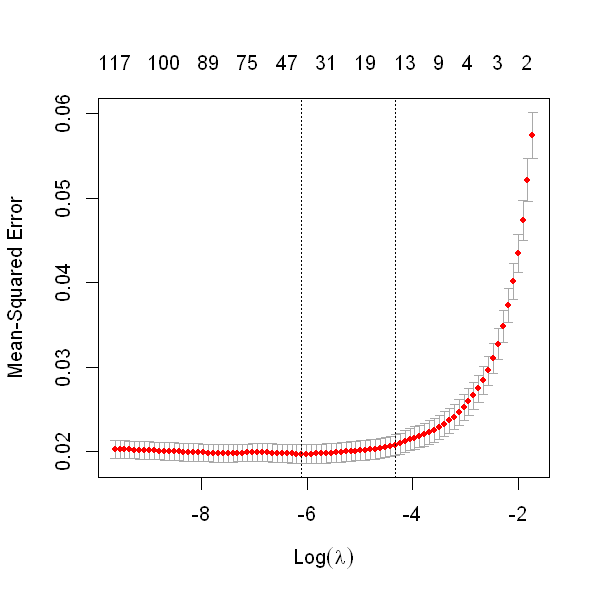

In [10]:
new_train<-as.matrix(crimetrain[,-1])
new_test<-as.matrix(crimetest[,-1])

cross_validation<-cv.glmnet(new_train,as.matrix(crimetrain$Class) ,family="gaussian", alpha=1)
options(repr.plot.width=5, repr.plot.height=5)
plot(cross_validation)

In [11]:
print(c("min lambda: ",cross_validation$lambda.min))

[1] "min lambda: "        "0.00224450441129142"


- **The best lambda value is found as 0.0022445.**

In [12]:
# model construction
fit <- glmnet(new_train,as.matrix(crimetrain$Class),family="gaussian", alpha=1,lambda=cross_validation$lambda.min)
summary(fit)

          Length Class     Mode   
a0          1    -none-    numeric
beta      122    dgCMatrix S4     
df          1    -none-    numeric
dim         2    -none-    numeric
lambda      1    -none-    numeric
dev.ratio   1    -none-    numeric
nulldev     1    -none-    numeric
npasses     1    -none-    numeric
jerr        1    -none-    numeric
offset      1    -none-    logical
call        6    -none-    call   
nobs        1    -none-    numeric

In [13]:
# predictions for train data
predictions <- predict(fit, new_train)
# accuracy for train data
outcome<-cbind(crimetrain$Class, data.frame(predictions))
rss <- sum((outcome[,2] - outcome[,1]) ^ 2)  ## residual sum of squares
tss <- sum((outcome[,1] - mean(outcome[,1])) ^ 2)  ## total sum of squares
rsq <- 1 - rss/tss
print(c("coefficient of determination (train):",rsq))

[1] "coefficient of determination (train):"
[2] "0.681827284364843"                    


In [15]:
# predictions for test data
predictions <- predict(fit, new_test)
# summarize accuracy for test data
outcome<-cbind(crimetest$Class, data.frame(predictions))
rss <- sum((outcome[,2] - outcome[,1]) ^ 2)  ## residual sum of squares
tss <- sum((outcome[,1] - mean(outcome[,1])) ^ 2)  ## total sum of squares
rsq <- 1 - rss/tss
print(c("coefficient of determination (train):",rsq))

[1] "coefficient of determination (train):"
[2] "0.636191760427338"                    


- $R^2$ values for train and test data are 0.681827 and 0.636192, respectively.

## Decision Tree

In decision tree approach, for **the minimal number of observations per tree leaf** 2,3,4 and 5 are used; for **the complexity parameter** 0.005, 0.01, 0.015 and 0.02 are used.

In [17]:
library(rpart)
set.seed(105)

decision_tree <- function(i){
    dtree1<-rpart(Class~.,data = crimetrain,control = rpart.control(minbucket = 2+i,cp=0.005*i),method = "anova")
    require(rpart.plot)
    rpart.plot(dtree1,type = 3,digits = 3,fallen.leaves = TRUE)
  
    predictions<-predict(dtree1,crimetest)
    outcome<-cbind(crimetest$Class, data.frame(predictions))
    rss <- sum((outcome[,2] - outcome[,1]) ^ 2)  ## residual sum of squares
    tss <- sum((outcome[,1] - mean(outcome[,1])) ^ 2)  ## total sum of squares
    rsq <- 1 - rss/tss
    print(c("coefficient of determination:",rsq))
    
    plotcp(dtree1)
    return(rsq)
}  

In [18]:
coffs = list()

Loading required package: rpart.plot
Warning message:
"package 'rpart.plot' was built under R version 3.6.3"

[1] "coefficient of determination:" "0.508236421892215"            


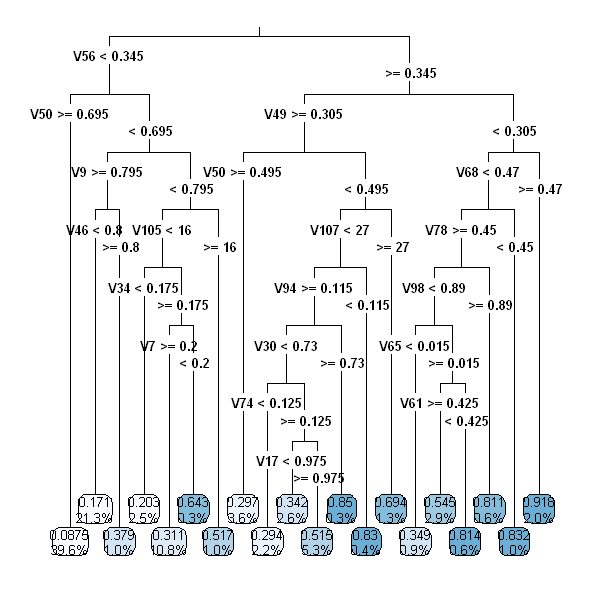

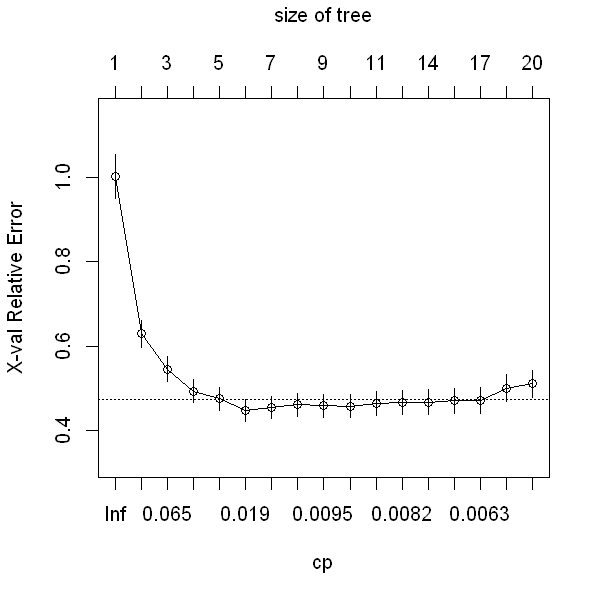

In [19]:
c = decision_tree(1)
coffs = append(coffs,c)

[1] "coefficient of determination:" "0.559448930259813"            


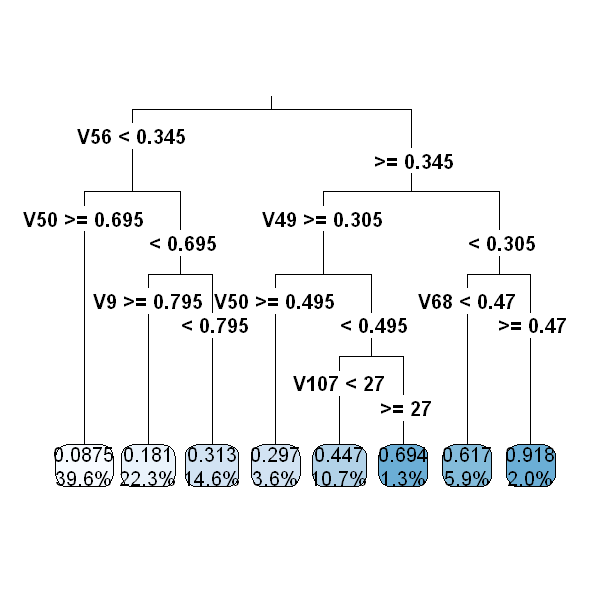

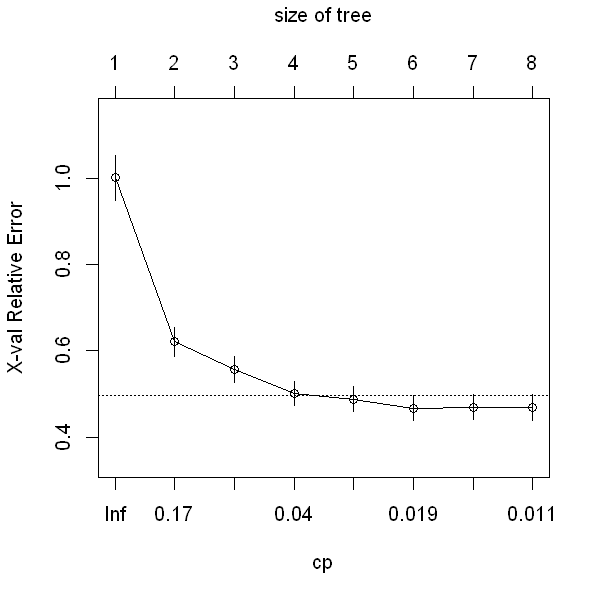

In [20]:
c = decision_tree(2)
coffs = append(coffs,c)

[1] "coefficient of determination:" "0.541027676814469"            


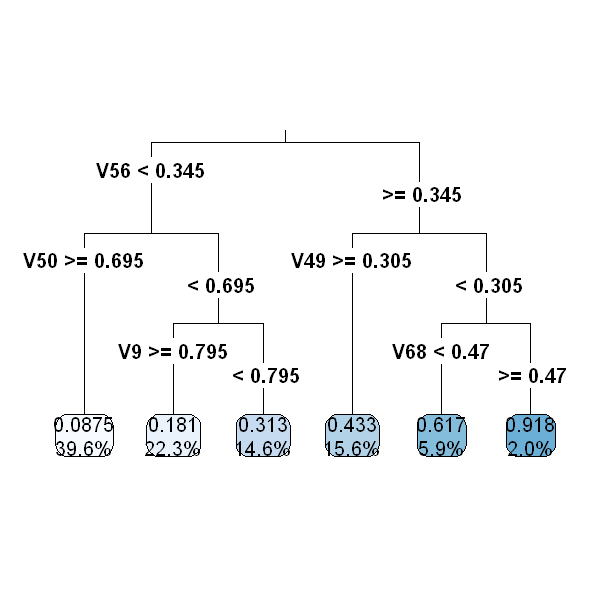

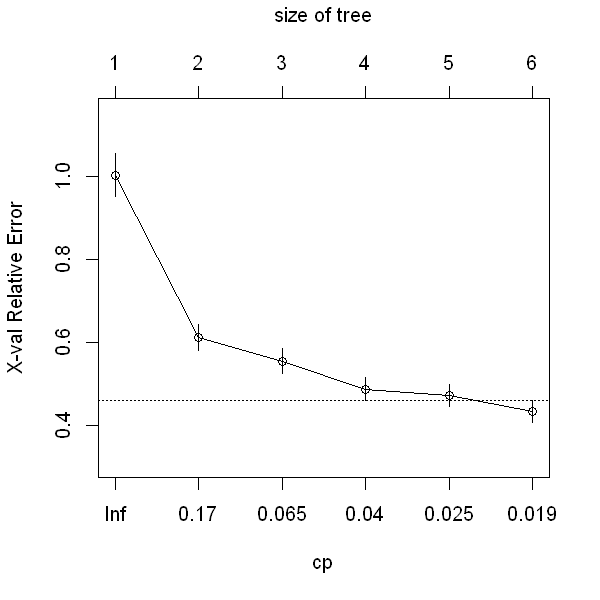

In [21]:
c = decision_tree(3)
coffs = append(coffs,c)

[1] "coefficient of determination:" "0.541027676814469"            


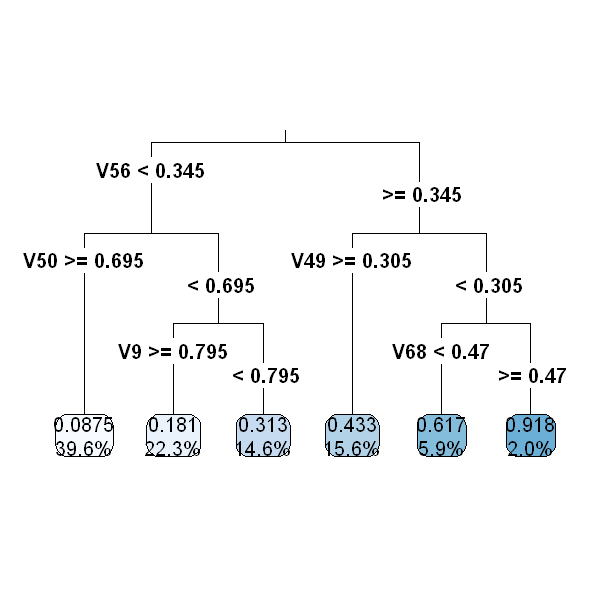

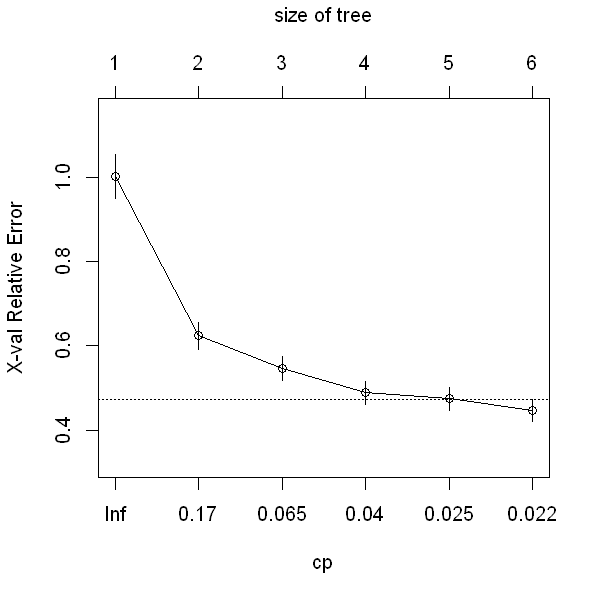

In [22]:
c = decision_tree(4)
coffs = append(coffs,c)

In [23]:
coffs

[[1]]
[1] 0.5082364

[[2]]
[1] 0.5594489

[[3]]
[1] 0.5410277

[[4]]
[1] 0.5410277

- Comparing the models considering the coefficient of determination, the best model is found with **the minimal number of observations per tree leaf as 4** and **the complexity parameter as 0.01** and its coefficient of determination is *0.559449*.

## Random Forest

In random forest approach, J trees are fit to bootstrap samples using a random sample of m features on which to split each
node. I used (11,12,13,14,15) as m in each iteration to find the best value.

In [24]:
require(randomForest)
library(cowplot)

Loading required package: randomForest
Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'cowplot' was built under R version 3.6.3"

In [25]:
set.seed(105)

random_forest <- function(i){
    model<-randomForest(Class~.,data=crimetrain,proximity=TRUE,mtry=10+i)
    print(model)
    
    predictions<-predict(model,crimetest)
    outcome<-cbind(crimetest$Class, data.frame(predictions))
    rss <- sum((outcome[,2] - outcome[,1]) ^ 2)  ## residual sum of squares
    tss <- sum((outcome[,1] - mean(outcome[,1])) ^ 2)  ## total sum of squares
    rsq <- 1 - rss/tss
    print(c("coefficient of determination:",rsq))
    
    return(rsq)
}

In [26]:
err <- list()

In [27]:
e = random_forest(1)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = crimetrain, proximity = TRUE,      mtry = 10 + i) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 11

          Mean of squared residuals: 0.01987709
                    % Var explained: 65.51
[1] "coefficient of determination:" "0.661396804364963"            


In [28]:
e = random_forest(2)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = crimetrain, proximity = TRUE,      mtry = 10 + i) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 12

          Mean of squared residuals: 0.01991597
                    % Var explained: 65.45
[1] "coefficient of determination:" "0.664359772182272"            


In [29]:
e = random_forest(3)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = crimetrain, proximity = TRUE,      mtry = 10 + i) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 0.01971767
                    % Var explained: 65.79
[1] "coefficient of determination:" "0.660013666209761"            


In [30]:
e = random_forest(4)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = crimetrain, proximity = TRUE,      mtry = 10 + i) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 14

          Mean of squared residuals: 0.01980545
                    % Var explained: 65.64
[1] "coefficient of determination:" "0.662374874477233"            


In [31]:
e = random_forest(5)
err = append(err,e)


Call:
 randomForest(formula = Class ~ ., data = crimetrain, proximity = TRUE,      mtry = 10 + i) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 15

          Mean of squared residuals: 0.01975825
                    % Var explained: 65.72
[1] "coefficient of determination:" "0.66453127538367"             


In [32]:
err

[[1]]
[1] 0.6613968

[[2]]
[1] 0.6643598

[[3]]
[1] 0.6600137

[[4]]
[1] 0.6623749

[[5]]
[1] 0.6645313

- All $R^2$ values are almost equal, but slightly the fifth model which has m value of 15 is better than others.

## Stochastic Gradient Boosting


In [33]:
library(caret)
require(gbm)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Loading required package: gbm
Warning message:
"package 'gbm' was built under R version 3.6.3"Loaded gbm 2.1.8


,var,rel.inf
V50,V50,26.5039975
V56,V56,18.1225030
V9,V9,11.6423778
V55,V55,10.8671952
V49,V49,5.3573688
V74,V74,4.8588777
V46,V46,3.7164739
V75,V75,2.5809681
V77,V77,2.1282643
V96,V96,1.9598227


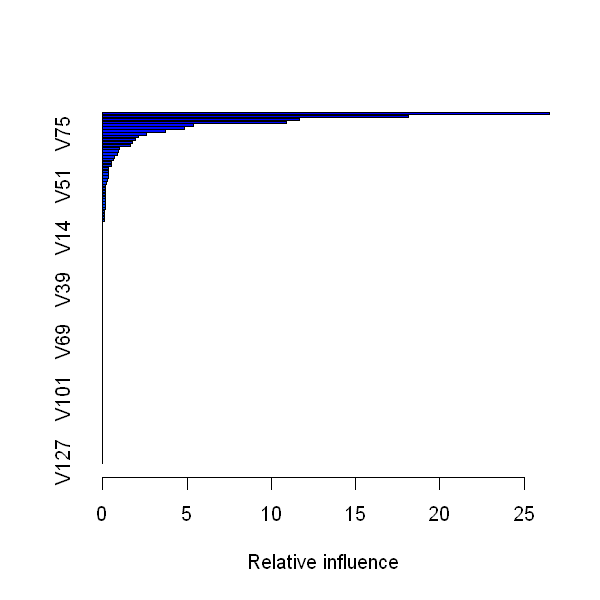

In [34]:
trcontrol<-trainControl(method = "repeatedcv",number=5)
set.seed(123)

gbm_tree<-gbm(Class~.,data = crimetrain,distribution="gaussian",cv.folds = 3)
summary(gbm_tree)

In [36]:
predictions<-predict(gbm_tree,crimetest,n.trees = 100)
outcome<-cbind(crimetest$Class, data.frame(predictions))
rss <- sum((outcome[,2] - outcome[,1]) ^ 2)  ## residual sum of squares
tss <- sum((outcome[,1] - mean(outcome[,1])) ^ 2)  ## total sum of squares
rsq <- 1 - rss/tss
print(c("coefficient of determination:",rsq))

[1] "coefficient of determination:" "0.647522647829253"            


- $R^2$ values for the best model of each approach are given below:

| Penalized Regression | Decision Tree | Random Forest | Stochastic Gradient Boosting |
| --- | --- | --- | --- |
| 0.636192 | 0.559449 | 0.664531 | 0.647522 |

- According to these values, we can say that **random forest model** performs better compared to other models.